In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner
from rochev.hputil import *
from rochev.ldgdutil import lgcoeffs
from rochev import fvmodel_y as fvmodel
from rochev import get_ccfvel_itrnr as get_ccfvel
import dill

In [2]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer import init_to_value
from jax.config import config
import jax.numpy as jnp
from jax import random
import celerite2
from celerite2.jax import terms as jax_terms
config.update('jax_platform_name', 'cpu')
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

You can squash this warning by setting the environment variable 'JAX_ENABLE_X64=True' or by running:
>>> from jax.config import config
>>> config.update('jax_enable_x64', True)


In [3]:
%config InlineBackend.figure_formats = {'png', 'retina'}
import seaborn as sns
sns.set(font="times",font_scale=1.4,style="ticks")
sns.set_palette('colorblind')
plt.rcParams["figure.figsize"] = (18,6)
from matplotlib import rc
rc('text', usetex=False)

In [4]:
from astropy.constants import au, R_sun, M_sun, G
ar0 = (au/R_sun).value
vsini0 = (R_sun*2*np.pi/86400).value*1e-3
rho0 = (M_sun/R_sun**3/(4*np.pi/3)).value*1e-3
rho_crit = (3*np.pi/60**2/86400**2/G).value*1e-3
rho_crit0 = rho_crit/rho0

In [5]:
print(f"vsini0 = {vsini0}, [2piR/1year(s)]")
print(f"rho0 = {rho0}")
print(f"rho_crit = {rho_crit}")
print(f"rho_crit0 = {rho_crit0}")

vsini0 = 50.59273169218562, [2piR/1year(s)]
rho0 = 1.409779824307526
rho_crit = 5.254548657992502e-06
rho_crit0 = 3.727212269173663e-06


# data

In [6]:
data = pd.read_csv("s12_rv.csv")
dlab = 'S12'
t = jnp.array(data.BJD)
y = jnp.array(data.rv)
yerr = jnp.array(data.rv_err)
t_epoch = t[0]
wavmin, wavmax = 388, 882 # wavelength coverage
idx = t!=2454073.62965 # outlier
print (t_epoch)

2454065.57926


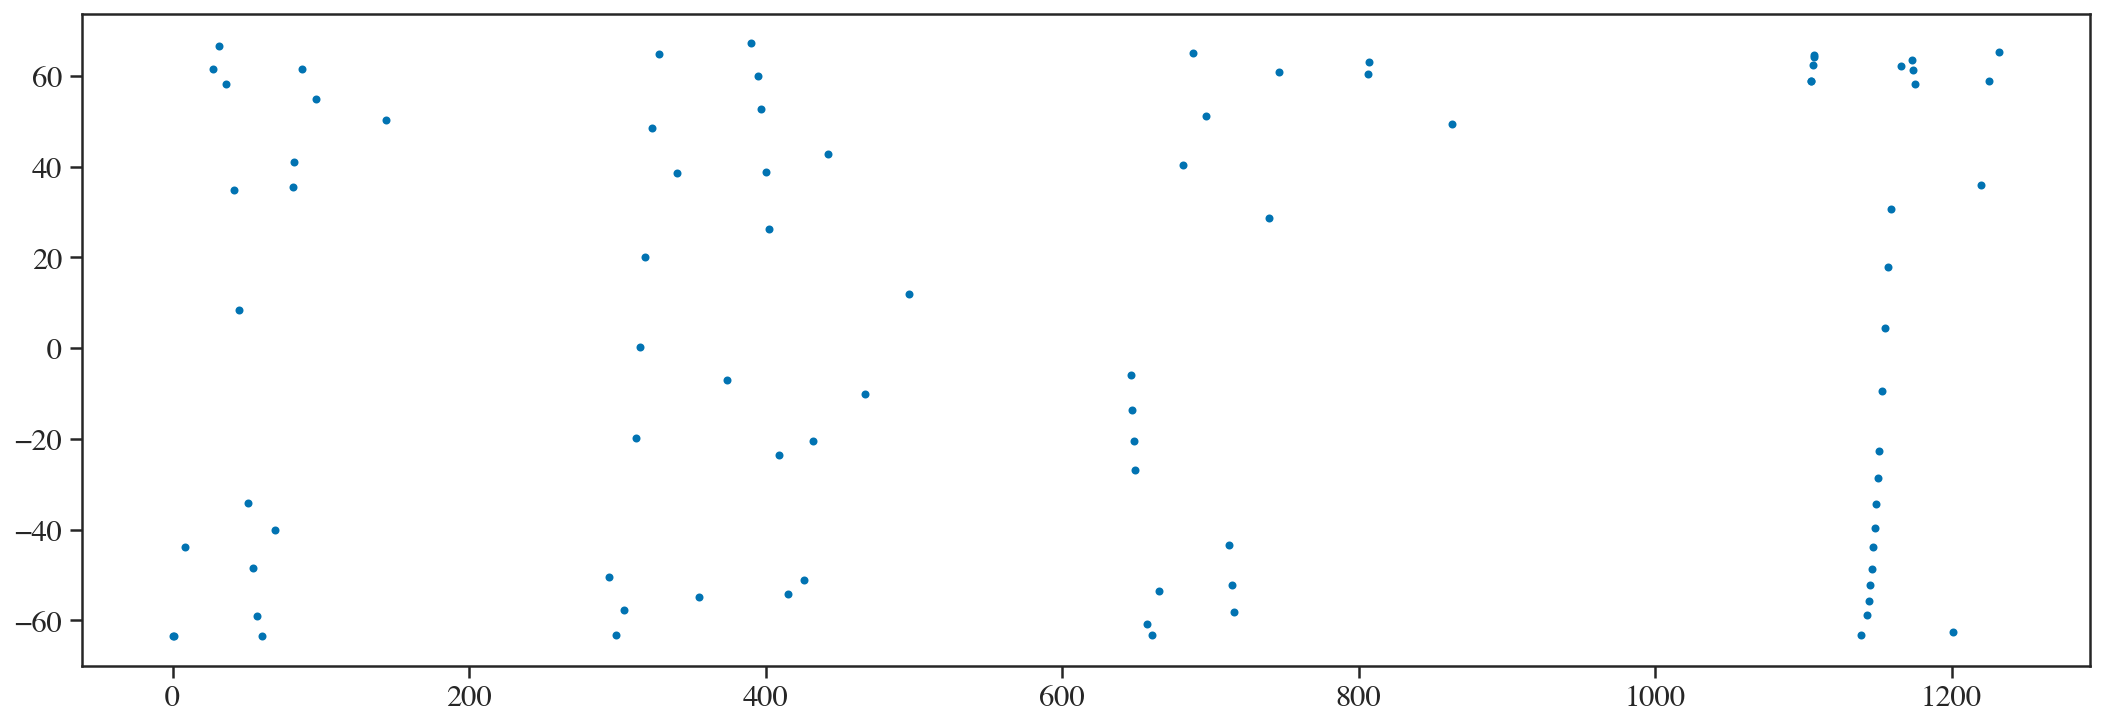

In [7]:
t -= t_epoch
t, y, yerr = t[idx], y[idx], yerr[idx]
plt.plot(t, y, '.')

# model

In [8]:
comp = "w/" # "w/o" or "w/"
grid = "ispec" # "coellho" or "ispec"

In [9]:
def physical_model(t, y, yerr, vsini_obs, vsini_obs_err, minfo):
    m1 = numpyro.sample("m1", dist.TruncatedNormal(loc=1., scale=0.5, low=0.1))
    r1 = numpyro.sample("r1", dist.Uniform(low=15.,high=30.))
    lnq = numpyro.sample("lnq", dist.Uniform(low=0, high=3))
    q = jnp.exp(lnq)
    m2 = m1 * q
    cosi = numpyro.sample("cosi", dist.Uniform(low=0, high=1))
    inc = jnp.arccos(cosi)

    # inc = numpyro.sample("inc", dist.Uniform(low=0, high=jnp.pi/2)) # sampling "inc" from uniform prior (0, pi/2) radian
    # cosi = jnp.cos(inc)
    sini = jnp.sqrt(1.-cosi*cosi)
    fm = (m2*sini)**3 / (m1+m2)**2

    period = numpyro.sample("period", dist.Uniform(59.9, 60.0))
    #t0 = numpyro.sample("t0", dist.Uniform(19, 21)) # For G14
    t0 = numpyro.sample("t0", dist.Uniform(764.5, 765.5)) # For S12
    sma = (m1+m2)**(1./3.) * (period/365.25)**(2./3.) # AU
    a = ar0 * sma / r1

    _q = 1./q
    a_crit = (0.6*_q**(2./3.) + jnp.log(1+_q**(1./3.)))/(0.49*_q**(2./3.))
    numpyro.deterministic("acrit", a_crit)
    numpyro.factor("afactor", jnp.where(a > a_crit, 0, -jnp.inf))

    K = (fm/1.036e-7/period)**(1./3.)
    # K = K -1.0  # E22, 4.3.1 tidal RV; ... meaning that K_giant is underestimated by ~1 km s-1
    gamma = numpyro.sample("gamma", dist.Uniform(low=-10, high=10))
    # lnjit = numpyro.sample("lnjit", dist.Uniform(low=-5, high=0))
    # jit = jnp.exp(lnjit)

    vsini = vsini0 / period * sini * r1
    numpyro.deterministic("vsini", vsini)

    #weff = numpyro.sample("leff", dist.Uniform(wavmin, wavmax))
    #wc, wd = 0.5*(wavmin+wavmax), 0.25*(wavmax-wavmin)
    #numpyro.factor("logpleff", -0.5*(weff-wc)**2/wd**2)
    weff = 0.5 * (wavmin + wavmax) # fixed for testing

    _ygd, _u1, _u2 = lgcoeffs(weff)
    ygd = numpyro.sample("ygd", dist.Normal(loc=_ygd, scale=0.1))
    u1 = numpyro.sample("u1", dist.Normal(loc=_u1, scale=0.1))
    u2 = numpyro.sample("u2", dist.Normal(loc=_u2, scale=0.1))

    numpyro.deterministic("m2", m2)
    numpyro.deterministic("K", K)
    numpyro.deterministic("massfunc", fm)
    numpyro.deterministic("mratio", q)
    numpyro.deterministic("a", a)

    x = (t-t0)/period * 2 * jnp.pi
    phases = x + 0.5*jnp.pi
    rvbase = -K * jnp.sin(x)
    numpyro.deterministic("rvmodel_base0", rvbase)
    rvbase = rvbase + gamma

    # prior from spectrum fit result
    if comp=="w/o" and grid=="coelho":
        vmac = numpyro.sample("vmac", dist.TruncatedNormal(loc=2.26, scale=1.23, low=0))
    if comp=="w/o" and grid=="ispec":
        vmac = numpyro.sample("vmac", dist.TruncatedNormal(loc=3.03, scale=1.09, low=0))
    if comp=="w/" and grid=="coelho":
        vmac = numpyro.sample("vmac", dist.TruncatedNormal(loc=2.40, scale=1.23, low=0))
    if comp=="w/" and grid=="ispec":
        vmac = numpyro.sample("vmac", dist.TruncatedNormal(loc=1.89, scale=1.15, low=0))

    dvsigma = numpyro.sample("dvsigma", dist.HalfNormal(scale=1.))
    vsigma = 2.95 + dvsigma
    numpyro.deterministic("vsigma", vsigma)

    Xf, V, cosg, _ = fvmodel(minfo, phases, inc, u1, u2, q, a, ygd)
    flux = jnp.sum(Xf, axis=1)
    vel_cent = vsini * jnp.sum(V*Xf, axis=1) / flux
    drv = get_ccfvel(vel_cent, Xf, V, cosg, vsini, vmac, vsigma)

    rvs = rvbase + drv
    numpyro.deterministic("rvmodel", rvs)
    numpyro.deterministic("rvmodel_base", rvbase)
    numpyro.deterministic("rvmodel_anom", drv)
    numpyro.deterministic("fluxmodel", flux)

    res = y - rvs
    # sigma2 = yerr**2 + jit**2
    # lnsigma2 = jnp.log(sigma2)

    res_vsini = vsini_obs - vsini
    sigma2vsini = vsini_obs_err**2
    lnsigma2vsini = jnp.log(sigma2vsini)

    # loglikelihood = -0.5 * jnp.sum(res**2/sigma2 + lnsigma2) \
    #                 -0.5 * jnp.sum(res_vsini**2/sigma2vsini + lnsigma2vsini)
    loglikelihood = -0.5 * jnp.sum(res_vsini**2/sigma2vsini + lnsigma2vsini)

    numpyro.factor("loglike", loglikelihood)

    lna = numpyro.sample("lna", dist.Uniform(low=-5, high=0))
    lnc = numpyro.sample("lnc", dist.Uniform(low=-5, high=2))
    kernel = jax_terms.Matern32Term(sigma=jnp.exp(lna), rho=jnp.exp(lnc))
    lnsigma_max = -3
    lnsigma = numpyro.sample("lnsigma", dist.Uniform(low=-10, high=lnsigma_max))
    diags = yerr**2 + jnp.exp(2*lnsigma)

    gp = celerite2.jax.GaussianProcess(kernel, mean=0.0)
    gp.compute(t, diag=diags)

    numpyro.sample("obs", gp.numpyro_dist(), obs=res)

## measured vsini

In [10]:
# Data from spectrum fit result
if comp=="w/o" and grid=="coelho":
    vsini_obs, vsini_obs_err = 15.96, 0.42
if comp=="w/o" and grid=="ispec":
    vsini_obs, vsini_obs_err = 16.01, 0.44
if comp=="w/" and grid=="coelho":
    vsini_obs, vsini_obs_err = 16.03, 0.43
if comp=="w/" and grid=="ispec":
    vsini_obs, vsini_obs_err = 15.81, 0.40

# setting

In [11]:
#%% choose resolution of healpix map
nside = 8 #should be >=8
minfo = hpmap_info(create_hpmap(nside))

approximate resolution: 7.33deg


In [12]:
pnames = ["m1", "r1", "lnq", "inc", "period", "t0", "gamma", "lnjit", "ygd", "u1", "u2", "vmac", "dvsigma"] # parameters
param_opt = jnp.array([0.5, 20., 1., 0.3, 59.95, 765., 0, -2., 0.2, 0.2, 0.2, 2.5, 1.5]) # init value
pdict_init = dict(zip(pnames, param_opt))
print ("# initial parameters for HMC:")
for key in pdict_init.keys():
    print (key, pdict_init[key])
init_strategy = init_to_value(values=pdict_init)

# initial parameters for HMC:
m1 0.5
r1 20.0
lnq 1.0
inc 0.3
period 59.95
t0 765.0
gamma 0.0
lnjit -2.0
ygd 0.2
u1 0.2
u2 0.2
vmac 2.5
dvsigma 1.5


In [13]:
kernel = numpyro.infer.NUTS(physical_model, target_accept_prob=0.9, init_strategy=init_strategy)
basename = "s12rv_n%d"%nside

In [14]:
n_sample = 500 # short run for testing

In [15]:
basename += '_s%d'%n_sample
print(basename)

s12rv_n8_s500


In [16]:
from jax import device_count
device = device_count()
print(f"device count is {device}")

device count is 4


# mcmc

In [16]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=n_sample, num_chains=4)

In [17]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, t, y, yerr, vsini_obs, vsini_obs_err, minfo, extra_fields=('potential_energy',))
mcmc.print_summary()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   dvsigma      1.13      0.79      1.01      0.00      2.20    733.72      1.00
     gamma      1.88      0.04      1.88      1.82      1.94   1255.78      1.00
       inc      1.41      0.11      1.43      1.25      1.57    487.73      1.00
       lna     -1.61      0.17     -1.61     -1.88     -1.34   1146.96      1.00
       lnc      0.91      0.37      0.93      0.32      1.49   1144.39      1.01
       lnq      1.82      0.10      1.82      1.66      1.98    906.37      1.00
   lnsigma     -6.46      2.04     -6.39     -9.92     -3.69   1666.58      1.00
        m1      0.40      0.06      0.40      0.31      0.49    593.48      1.00
    period     59.94      0.00     59.94     59.93     59.94    642.34      1.00
        r1     19.35      0.70     19.27     18.19     20.30    373.65      1.01
        t0    764.97      0.01    764.97    764.95    764.98   1036.22      1.00
        u1      0.61      0

## save / load

In [17]:
# # save MCMC output
filename = "./mcmc_output/mcmc_ispec_fcomp_cosi_gp.pkl"
with open(filename, "wb") as f:
    dill.dump(mcmc, f)
#load MCMC output
# with open(filename, 'rb') as f:
    # mcmc = dill.load(f)
# mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   dvsigma      1.13      0.79      1.01      0.00      2.20    733.72      1.00
     gamma      1.88      0.04      1.88      1.82      1.94   1255.78      1.00
       inc      1.41      0.11      1.43      1.25      1.57    487.73      1.00
       lna     -1.61      0.17     -1.61     -1.88     -1.34   1146.96      1.00
       lnc      0.91      0.37      0.93      0.32      1.49   1144.39      1.01
       lnq      1.82      0.10      1.82      1.66      1.98    906.37      1.00
   lnsigma     -6.46      2.04     -6.39     -9.92     -3.69   1666.58      1.00
        m1      0.40      0.06      0.40      0.31      0.49    593.48      1.00
    period     59.94      0.00     59.94     59.93     59.94    642.34      1.00
        r1     19.35      0.70     19.27     18.19     20.30    373.65      1.01
        t0    764.97      0.01    764.97    764.95    764.98   1036.22      1.00
        u1      0.61      0

# sample

In [18]:
samples = mcmc.get_samples()

## corner plot

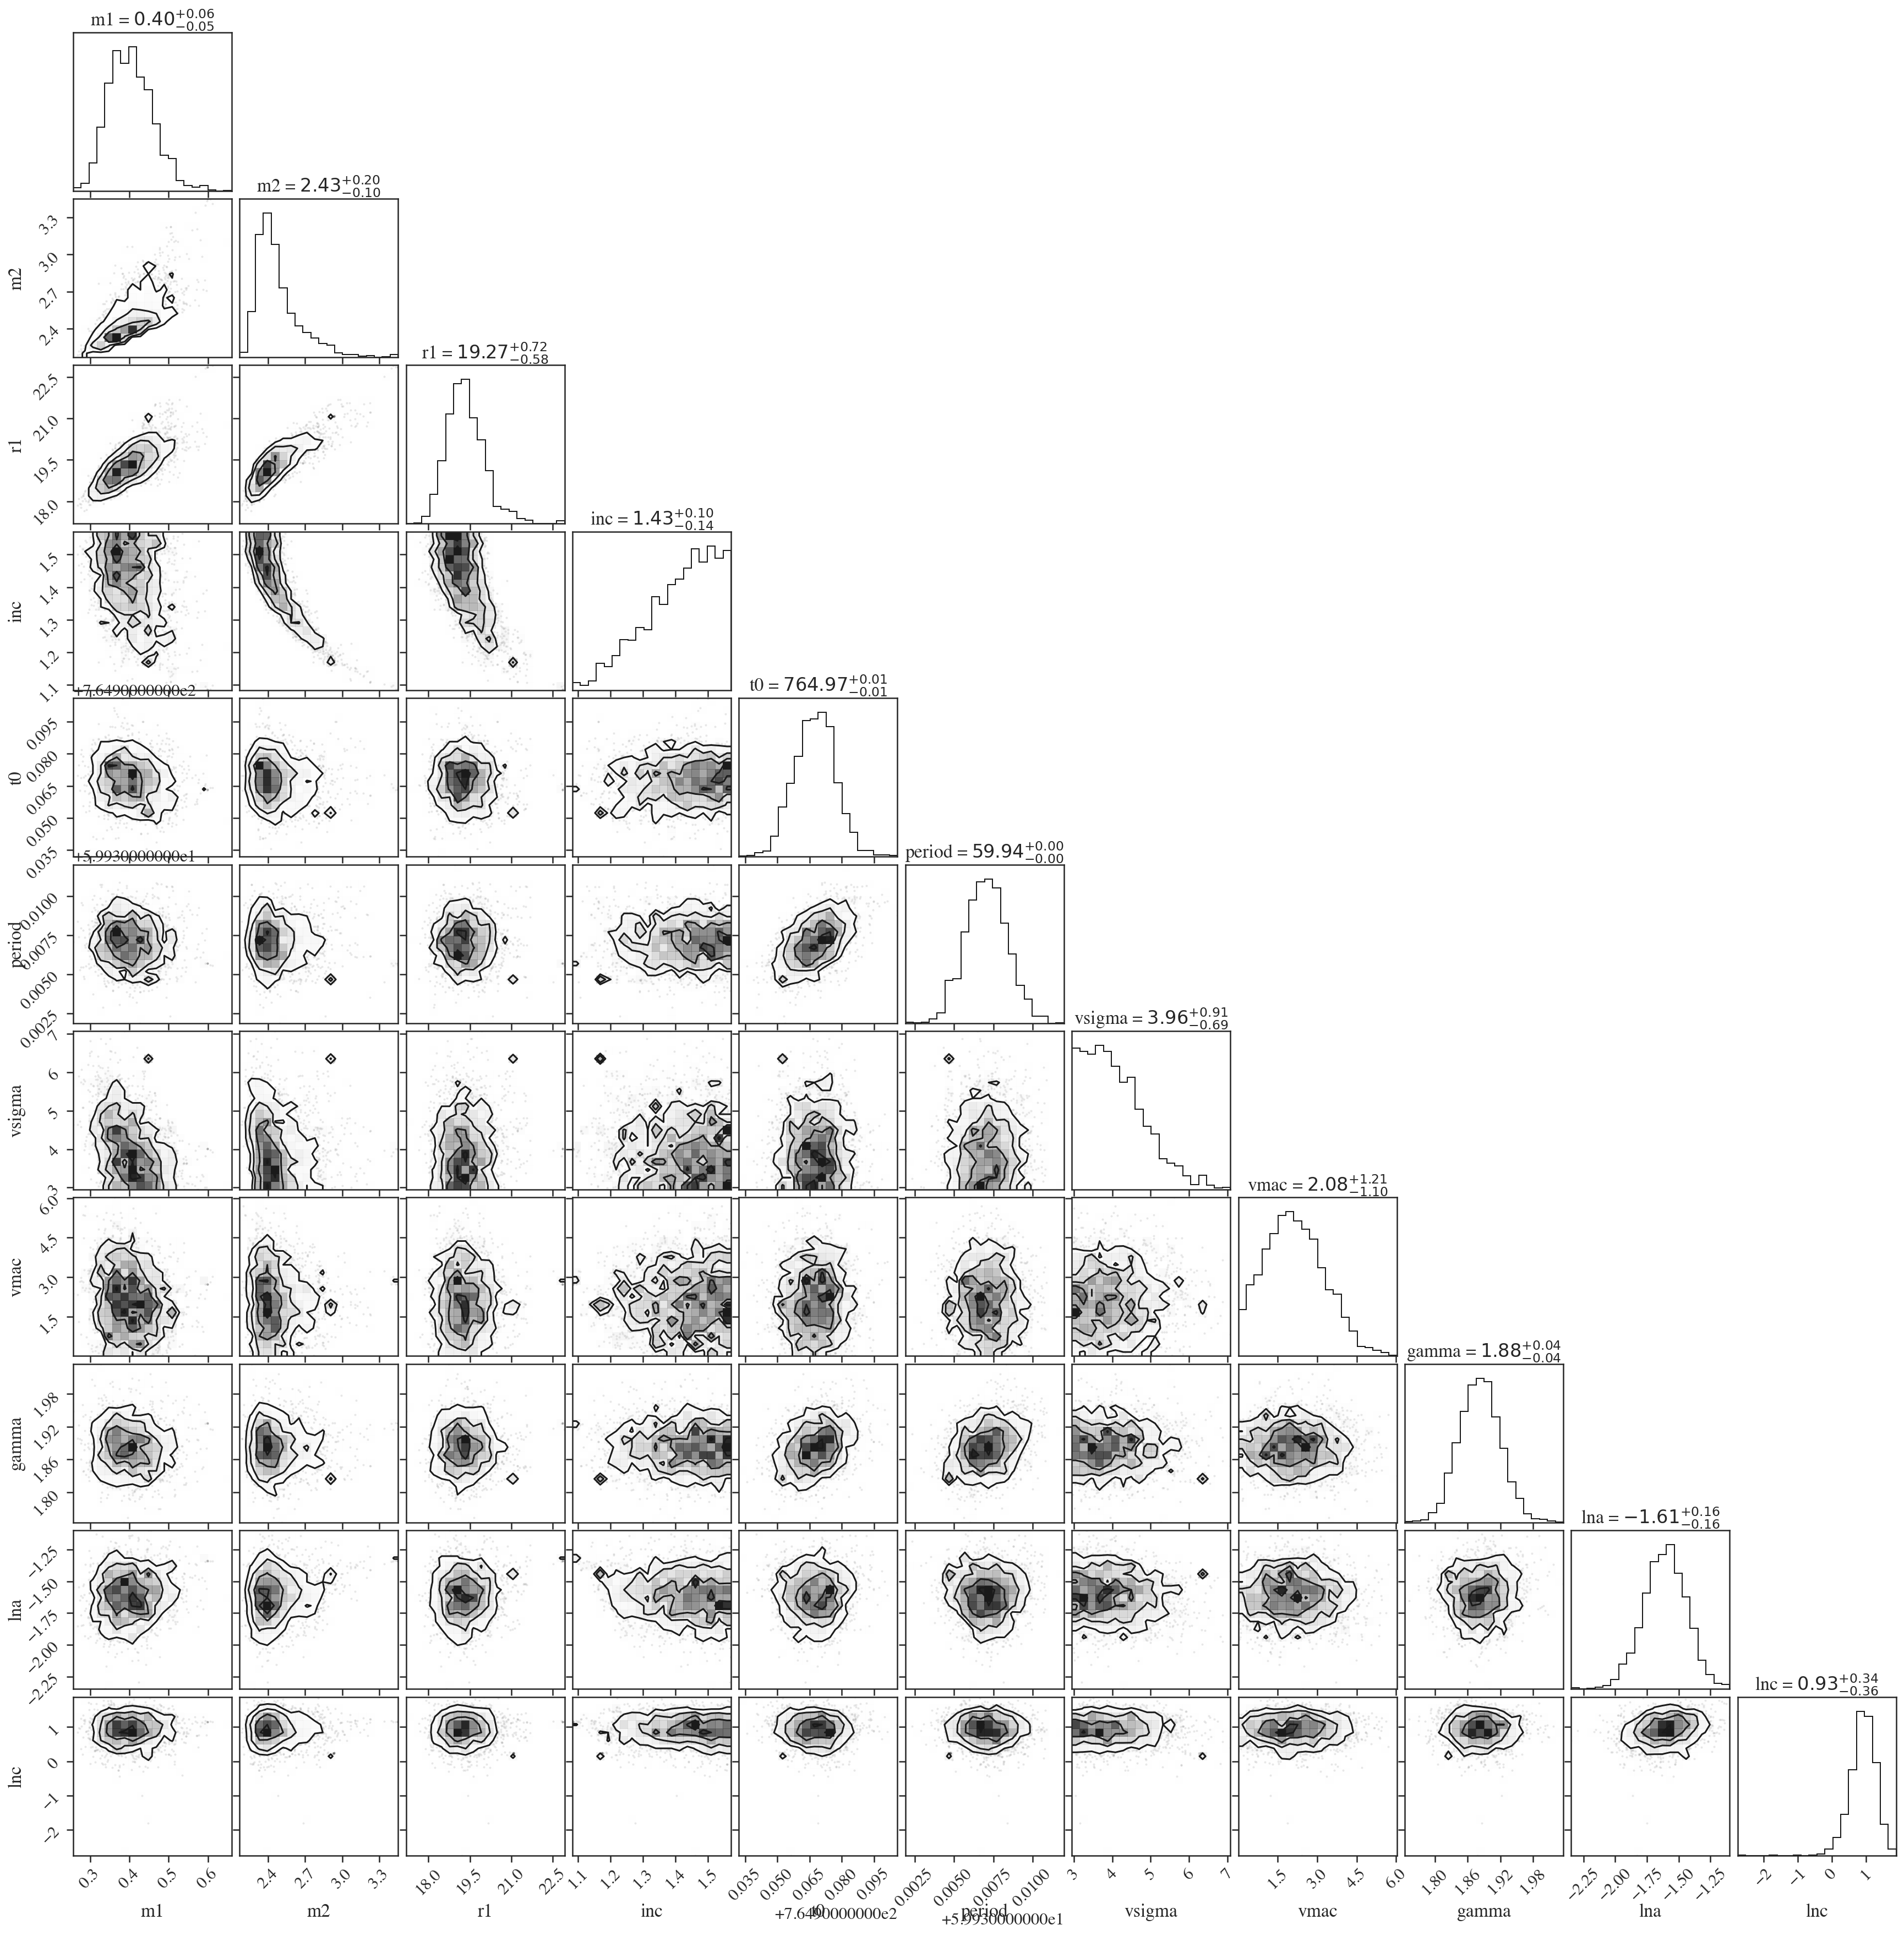

In [19]:
# keys = ["m1", "m2", "r1", "mratio", "t0", "period", "inc", "vsigma", "vmac", "gamma", "vsini", "lna", "lnc"]
keys = ["m1", "m2", "r1", "inc", "t0", "period", "vsigma", "vmac", "gamma", "lna", "lnc"]
labels = keys
hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
fig = corner.corner(hyper, labels=labels, show_titles="%.2f")

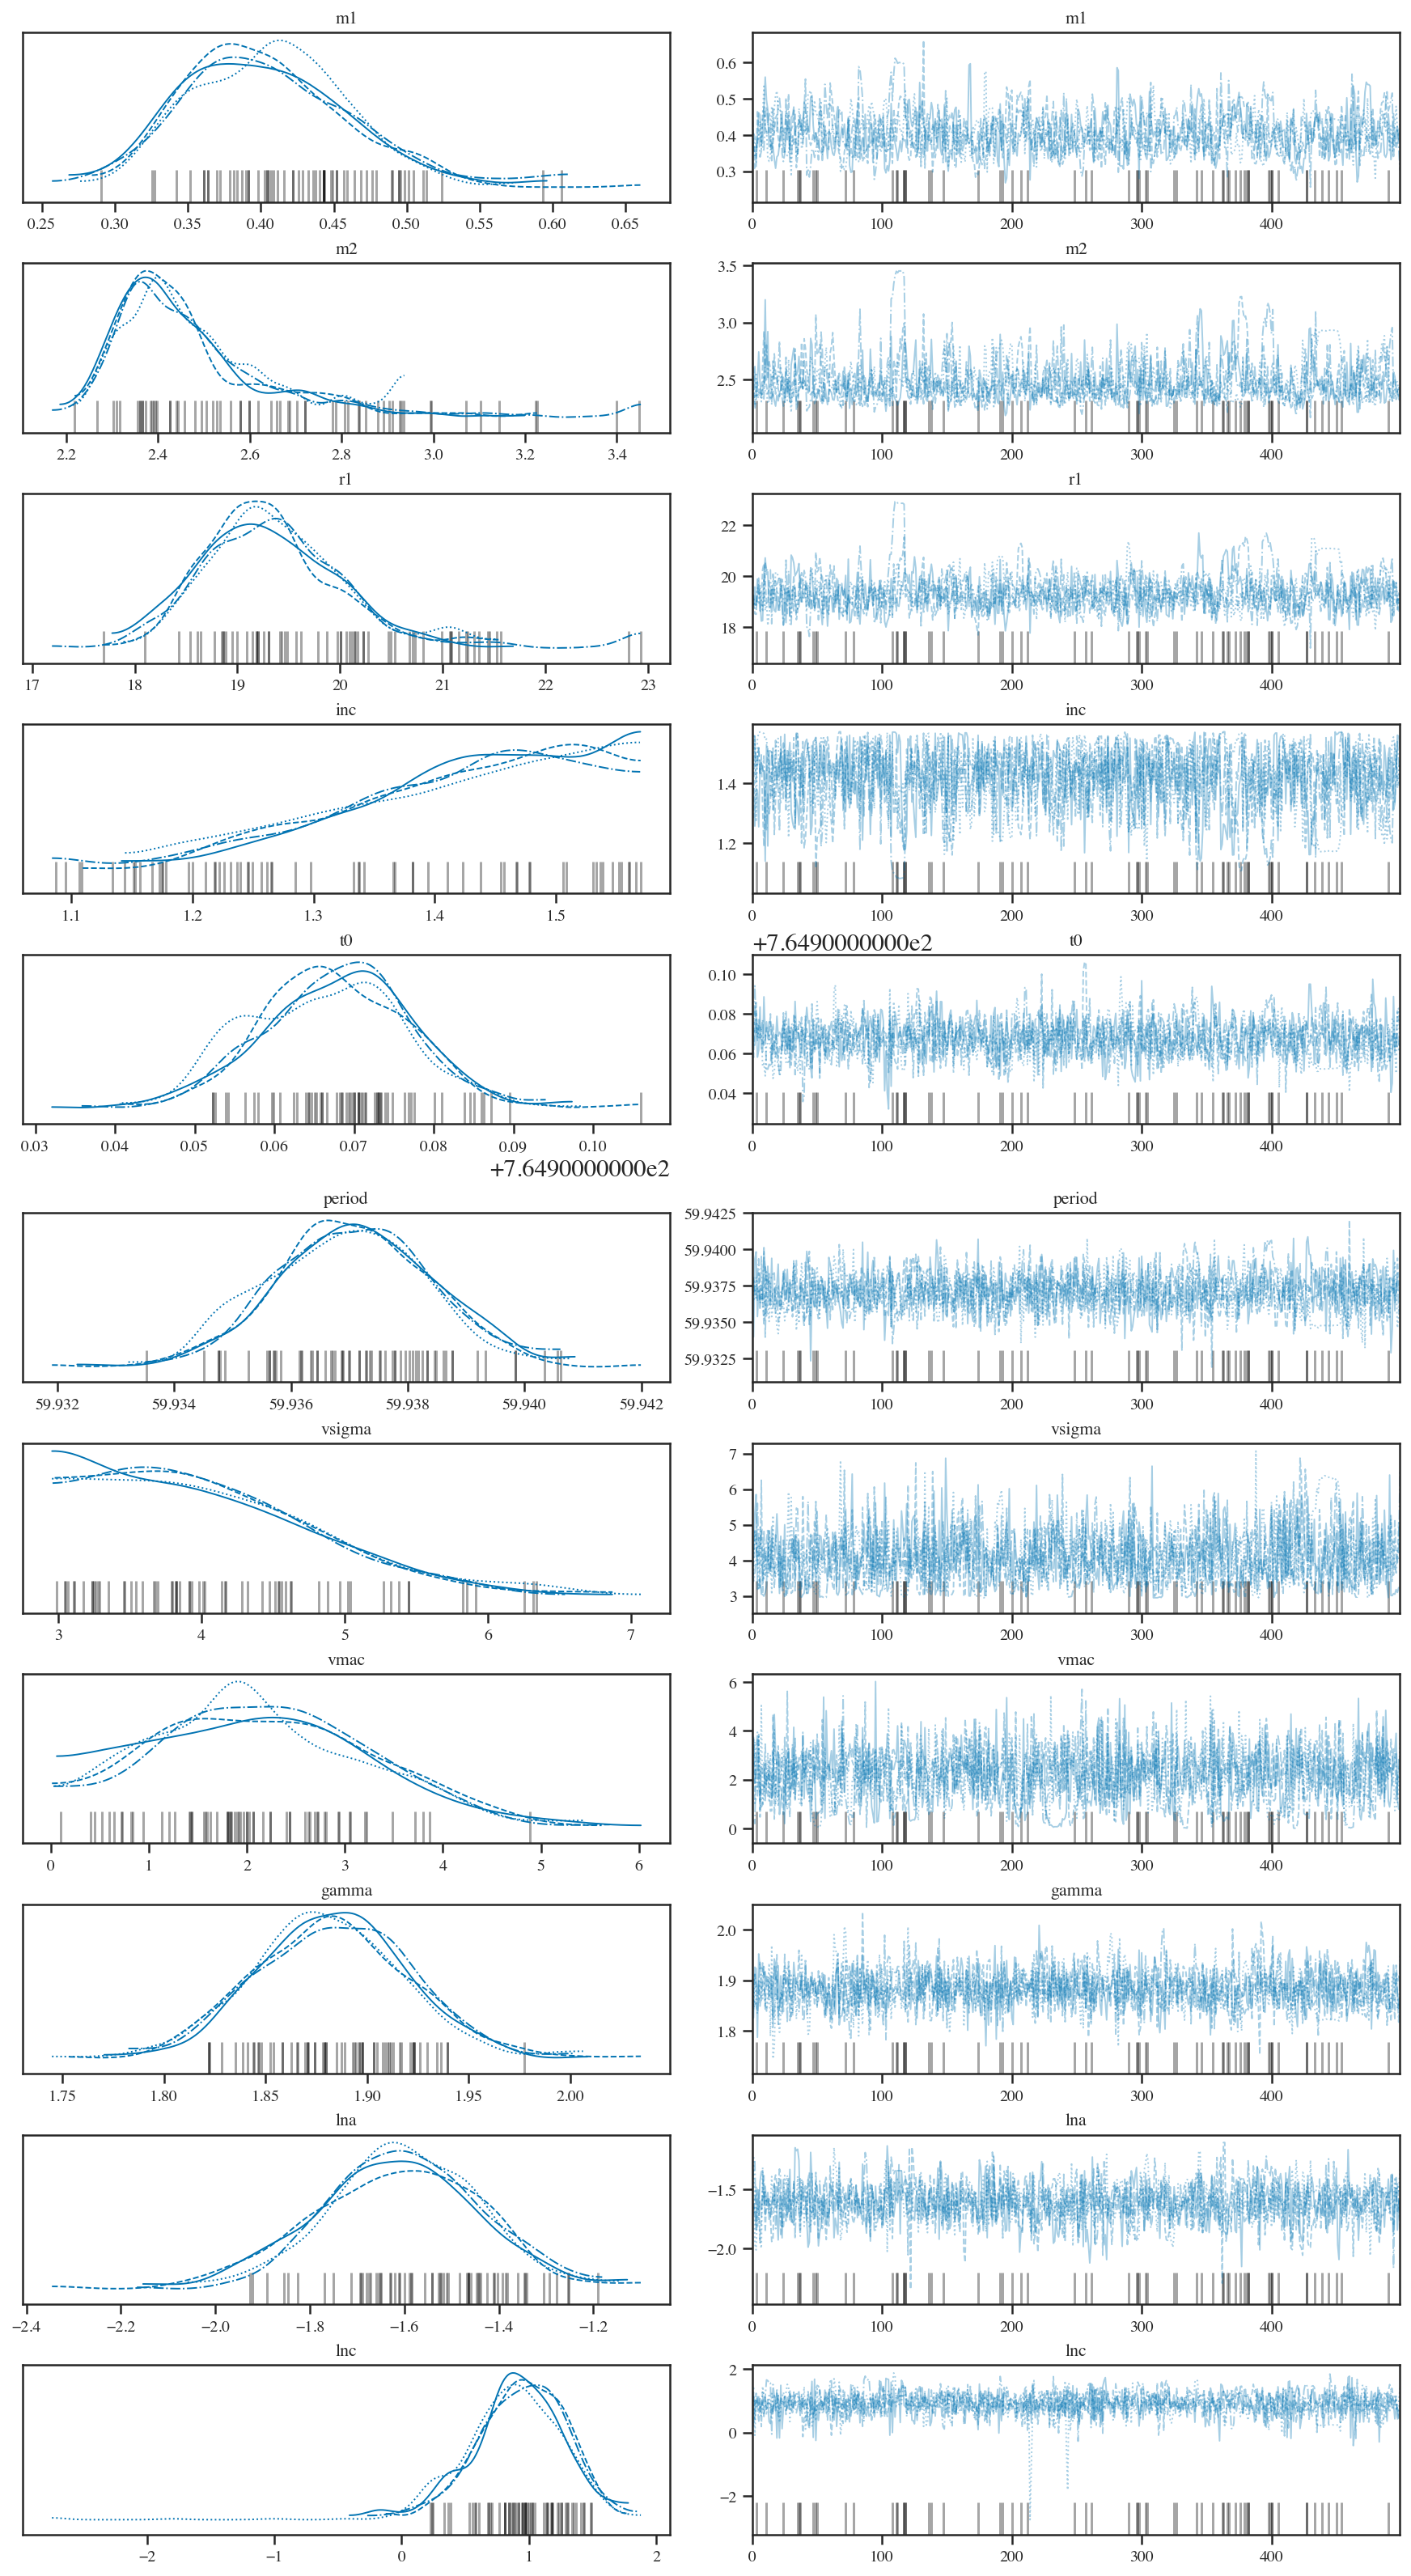

In [20]:
import arviz
fig = arviz.plot_trace(mcmc, var_names=keys)

<ErrorbarContainer object of 3 artists>

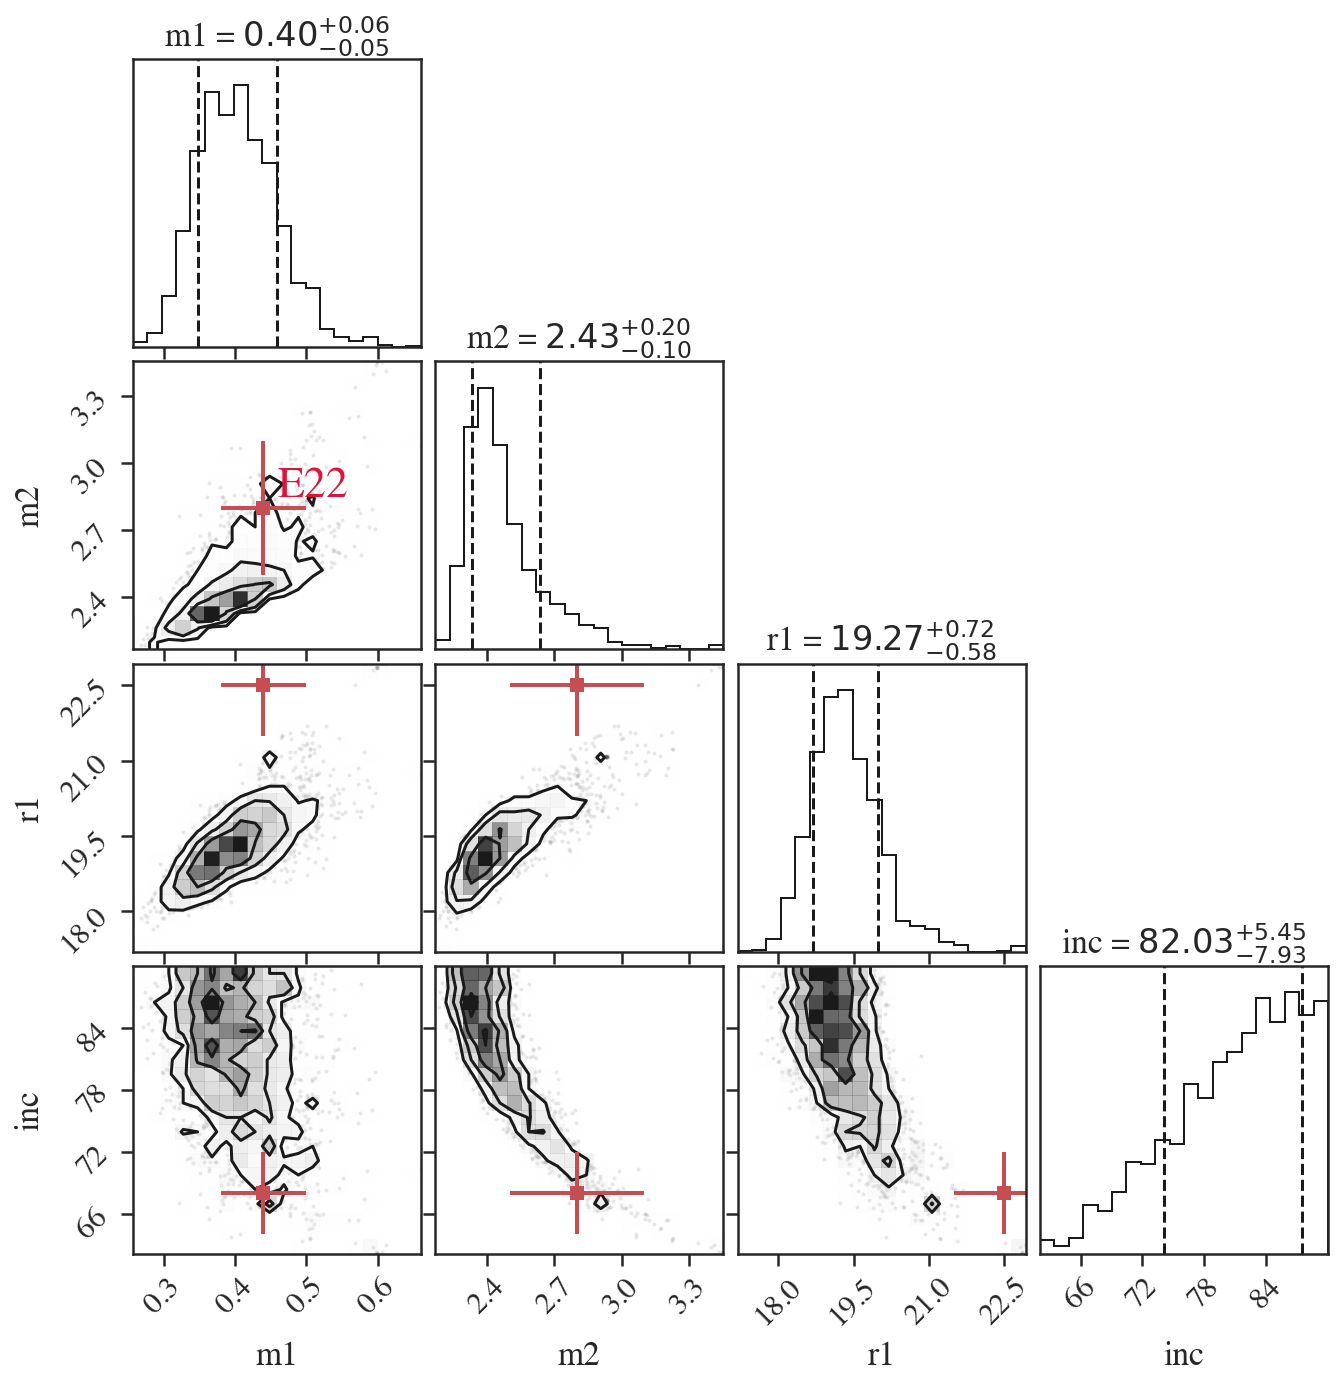

In [21]:
keys = ["m1", "m2", "r1"]
labels = keys
hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
hyper["inc"] = samples["inc"] * 180/jnp.pi
fig = corner.corner(hyper, labels=labels+["inc"],  quantiles=[0.16, 0.84], show_titles="%.2f")#, smooth=True)
# fig = corner.corner(hyper,  quantiles=[0.16, 0.84], show_titles="%.2f")

axes = np.array(fig.axes).reshape((4, 4))
axes[1,0].errorbar(0.44, 2.8, xerr=0.06, yerr=0.3, fmt="sr-", elinewidth=2) # El-Badry+2022
axes[1,0].text(0.44+0.02, 2.8+0.05, "E22", color="crimson", va="baseline", ha="left", fontsize=22)

axes[2,0].errorbar(0.44, 22.5, xerr=0.06, yerr=1.0, fmt="sr-", elinewidth=2) # m1 vs. r1
axes[3,0].errorbar(0.44, 68, xerr=0.06, yerr=4, fmt="sr-", elinewidth=2) # m1 vs. inc
axes[2,1].errorbar(2.8, 22.5, xerr=0.3, yerr=1.0, fmt="sr-", elinewidth=2) # m2 vs. r1
axes[3,1].errorbar(2.8, 68,  xerr=0.3, yerr=4, fmt="sr-", elinewidth=2) # m2 vs. inc
axes[3,2].errorbar(22.5, 68,  xerr=1.0, yerr=4, fmt="sr-", elinewidth=2) # r1 vs. inc

# calc for plot

## physical

In [22]:
rvmodels = np.array(mcmc.get_samples()["rvmodel"])
rvmodel_mean = np.mean(rvmodels, axis=0)
rvmodel_std = np.std(rvmodels, axis=0)

brvs = np.array(mcmc.get_samples()["rvmodel_base"])
brv_mean = np.mean(brvs, axis=0)
brv_std = np.std(brvs, axis=0)

brvs0 = np.array(mcmc.get_samples()["rvmodel_base0"])
brv0_mean = np.mean(brvs0, axis=0)
brv0_std = np.std(brvs0, axis=0)

drvs = np.array(mcmc.get_samples()["rvmodel_anom"])
drv_mean = np.mean(drvs, axis=0)
drv_std = np.std(drvs, axis=0)

fluxes = np.array(mcmc.get_samples()["fluxmodel"])
flux_mean = np.mean(fluxes, axis=0)
flux_std = np.std(fluxes, axis=0)

pbest = np.mean(mcmc.get_samples()["period"])
t0best = np.mean(mcmc.get_samples()["t0"])
x_phase = (t - t0best  + 0.5 * pbest) % pbest - 0.5 * pbest
idx = np.argsort(x_phase)

/Users/tomoyoshi/opt/anaconda3/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3302: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


## gp

In [23]:
ms = samples["rvmodel"][1000]
mres = y - samples["rvmodel"][1000]
lna = samples['lna'][1000]
lnc =  samples['lnc'][1000]
lnsigma = samples['lnsigma'][1000]
kernel = jax_terms.Matern32Term(sigma=jnp.exp(lna), rho=jnp.exp(lnc))
diags = yerr**2 + jnp.exp(2*lnsigma)
gp = celerite2.jax.GaussianProcess(kernel, mean=0.0)
gp.compute(t, diag=diags)
mgps = np.array([gp.predict(mres, t=t)]) + ms

In [24]:
gp_list = []
for i in range(2000):
    ms = samples["rvmodel"][i]
    mres = y - samples["rvmodel"][i]
    lna = samples['lna'][i]
    lnc =  samples['lnc'][i]
    lnsigma = samples['lnsigma'][i]
    kernel = jax_terms.Matern32Term(sigma=jnp.exp(lna), rho=jnp.exp(lnc))
    diags = yerr**2 + jnp.exp(2*lnsigma)
    gp = celerite2.jax.GaussianProcess(kernel, mean=0.0)
    gp.compute(t, diag=diags)
    mgps = np.array([gp.predict(mres, t=t)]) + ms

    gp_list.append(mgps)

gp_model = np.concatenate(gp_list, axis=0)
gp_model = np.mean(gp_model, axis=0)

# GP model

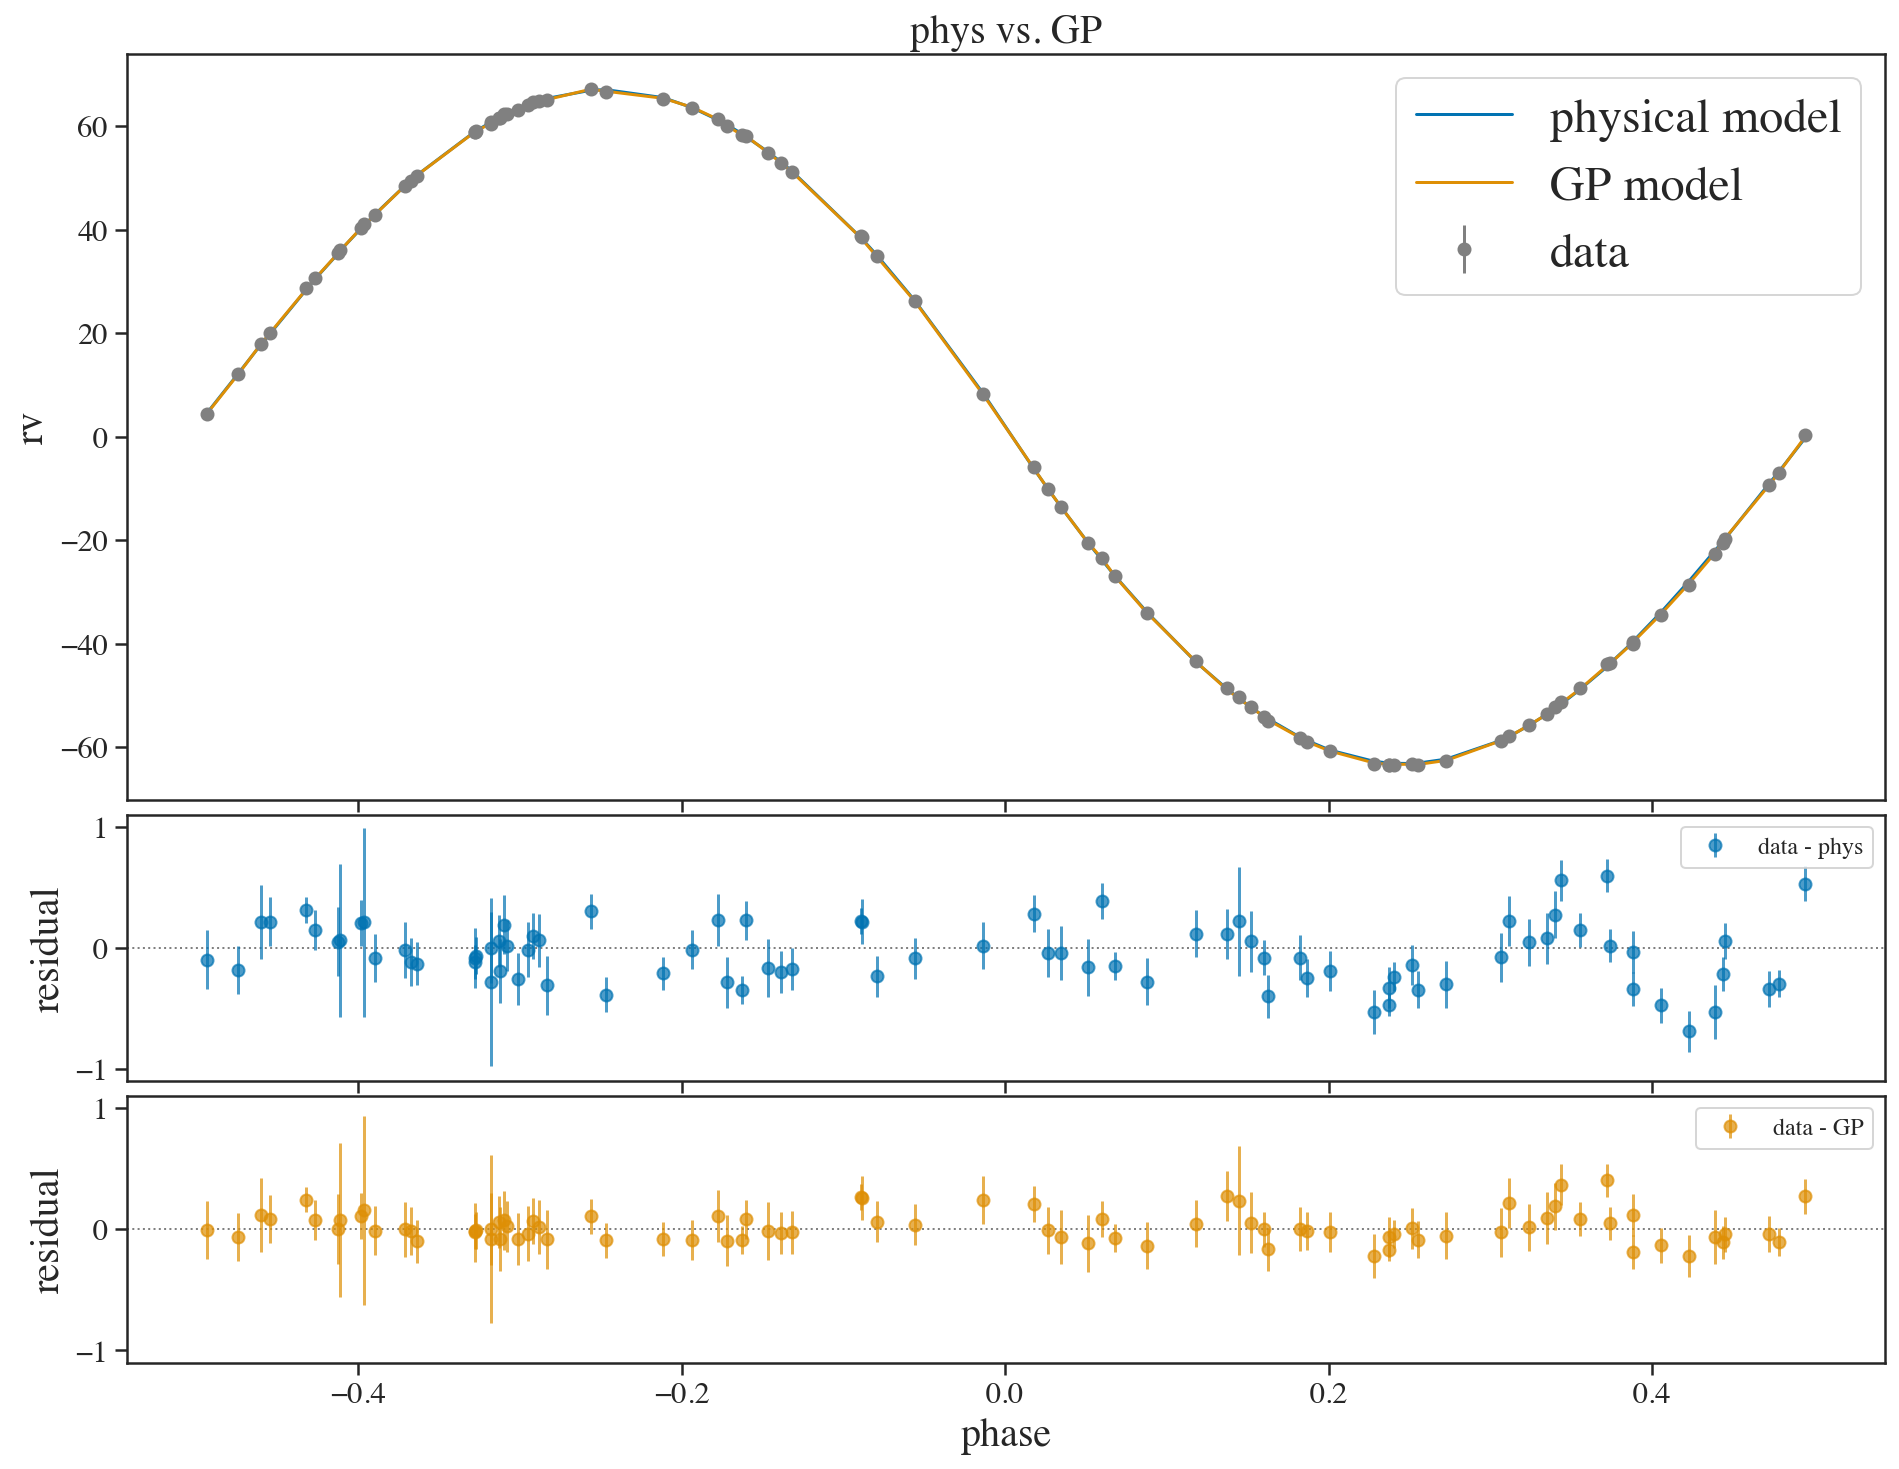

In [26]:
phase = x_phase[idx]/pbest
res_phys = y[idx] - ms[idx]
res_gp = y[idx] - gp_model[idx]
jitbest = jnp.sqrt(yerr**2)

fig, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2.8, 1, 1]}, figsize=(26*0.5, 20*0.5), sharex=True)

ax[0].errorbar(phase, y[idx], yerr=jitbest, fmt="o", c="gray", label="data")
ax[0].plot(phase, ms[idx], c="C0", label="physical model")
ax[0].plot(phase, gp_model[idx], c="C1", label="GP model")
ax[0].set_ylabel("rv", fontsize=20)
ax[0].legend(fontsize=24)

ax[1].errorbar(phase, res_phys, yerr=jitbest, fmt="o", c="C0", alpha=0.7, label="data - phys")
ax[1].set_ylim(-1.1, 1.1)
ax[1].set_ylabel("residual", fontsize=20)
ax[1].axhline(y=0, color='gray', lw=1, zorder=-1000, ls='dotted')
ax[1].legend(fontsize=12)

ax[2].errorbar(x_phase[idx]/pbest, res_gp, yerr=jitbest, fmt="o", c="C1", alpha=0.7, label="data - GP")
ax[2].set_ylim(-1.1, 1.1)
ax[2].axhline(y=0, color='gray', lw=1, zorder=-1000, ls='dotted')
ax[2].set_ylabel("residual", fontsize=20)
ax[2].set_xlabel("phase", fontsize=20)
ax[2].legend(fontsize=12)

ax[0].set_title("phys vs. GP", fontsize=20)
fig.tight_layout(pad=0.05)
# plt.savefig("./plot_phys_gp.png", dpi=150)